# 因子开发与回测示例

本 Notebook 展示了如何使用 `longgang_trader` 框架进行一次完整的因子开发和回测流程。

## 1. 加载数据

In [ ]:
from longgang_trader.data.data_loader import DataLoader

# 初始化数据加载器（此处应有配置文件）
dl = DataLoader(config={...})

# 加载数据
stock_data = dl.load_stock_data([...]) # type: ignore

## 2. 计算因子

In [ ]:
from longgang_trader.alpha.factor_calculator import MomentumFactor, FactorCalculator

# 创建一个20日动量因子
mom_factor = MomentumFactor(window=20)

# 使用因子计算器
calculator = FactorCalculator(stock_data)
calculator.add_factor(mom_factor)
factor_df = calculator.run()

## 3. 因子检验

In [ ]:
from longgang_trader.alpha.factor_testing import FactorTester

# 准备收益率数据
returns_data = ...

# 初始化因子检验器
tester = FactorTester(factor_df, returns_data, ...)

# 运行检验并查看结果
tester.run_all_tests()

## 4. 回测

In [ ]:
from longgang_trader.backtesting.backtester import Backtester, BaseStrategy

# 定义一个简单的分层回测策略
class SimpleLayeredStrategy(BaseStrategy):
    def generate_signals(self, current_date, current_positions):
        # 在每个调仓日，买入因子值最高的10%的股票，卖出最低的10%
        pass

# 初始化策略和回测器
strategy = SimpleLayeredStrategy(factor_df)
bt = Backtester(strategy, stock_data, initial_capital=10000000, transaction_cost=0.001)

# 运行回测
# 在运行前，请确保已经编译了Rust核心: `cargo build --release`
bt.run_backtest()

# 查看表现
bt.plot_equity_curve()
print(bt.calculate_performance_metrics())

## 虚拟数据测试

In [1]:
import pandas as pd
import numpy as np

# --- 创建虚拟股票数据 ---
# 日期范围
dates = pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04'])
# 股票列表
symbols = ['STOCK_A', 'STOCK_B', 'STOCK_C']

# 使用 MultiIndex 创建 DataFrame 结构
index = pd.MultiIndex.from_product([dates, symbols], names=['date', 'symbol'])
stock_data = pd.DataFrame(index=index).reset_index()

# 生成随机收盘价
np.random.seed(42)
stock_data['close'] = np.random.uniform(10, 20, size=len(stock_data))
# 模拟价格波动
stock_data['close'] = stock_data.groupby('symbol')['close'].transform(lambda x: x.cumsum())

print("虚拟股票数据 (stock_data):")
print(stock_data)
# --- 创建虚拟因子数据 ---
# 确保因子数据与股票数据的时间和代码对齐
factor_df = stock_data[['date', 'symbol']].copy()
# 生成随机因子值
factor_df['factor_value'] = np.random.randn(len(factor_df))

print("虚拟因子数据 (factor_df):")
print(factor_df)

虚拟股票数据 (stock_data):
         date   symbol      close
0  2023-01-01  STOCK_A  13.745401
1  2023-01-01  STOCK_B  19.507143
2  2023-01-01  STOCK_C  17.319939
3  2023-01-02  STOCK_A  29.731986
4  2023-01-02  STOCK_B  31.067329
5  2023-01-02  STOCK_C  28.879885
6  2023-01-03  STOCK_A  40.312822
7  2023-01-03  STOCK_B  49.729091
8  2023-01-03  STOCK_C  44.891035
9  2023-01-04  STOCK_A  57.393548
10 2023-01-04  STOCK_B  59.934936
11 2023-01-04  STOCK_C  64.590133
虚拟因子数据 (factor_df):
         date   symbol  factor_value
0  2023-01-01  STOCK_A     -0.469474
1  2023-01-01  STOCK_B      0.542560
2  2023-01-01  STOCK_C     -0.463418
3  2023-01-02  STOCK_A     -0.465730
4  2023-01-02  STOCK_B      0.241962
5  2023-01-02  STOCK_C     -1.913280
6  2023-01-03  STOCK_A     -1.724918
7  2023-01-03  STOCK_B     -0.562288
8  2023-01-03  STOCK_C     -1.012831
9  2023-01-04  STOCK_A      0.314247
10 2023-01-04  STOCK_B     -0.908024
11 2023-01-04  STOCK_C     -1.412304


项目根目录已添加至 sys.path: d:\Notes\Project\LongGangTrader
模块 'longgang_trader' 导入成功！

--- 开始执行回测 ---

生成的交易信号 (signals):
        date   symbol  target_weight
1 2023-01-01  STOCK_B            1.0
4 2023-01-02  STOCK_B            1.0
7 2023-01-03  STOCK_B            1.0
9 2023-01-04  STOCK_A            1.0
Rust 回测成功完成。

回测结果 (Portfolio History):
         date      equity
0  2023-01-01  10000000.0
1  2023-01-02   1000500.0
2  2023-01-03   1001000.0


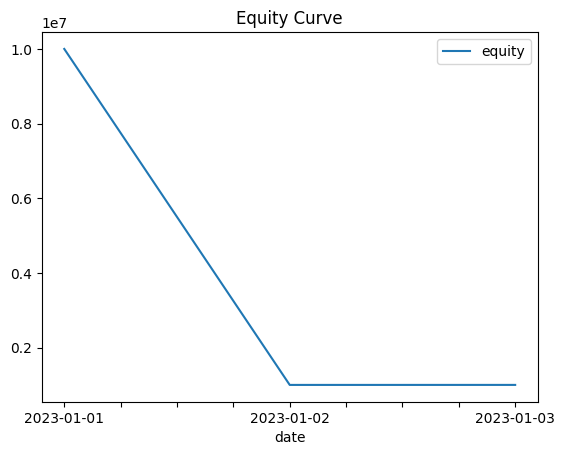

In [2]:
import sys
import os

# 将项目根目录添加到 Python 的模块搜索路径中
# 这使得 Notebook 可以成功导入 'longgang_trader' 模块
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"项目根目录已添加至 sys.path: {project_root}")

# 验证：现在应该可以成功导入了
try:
    import longgang_trader
    print("模块 'longgang_trader' 导入成功！")
except ImportError:
    print("错误：仍然无法导入 'longgang_trader'。")
from longgang_trader.backtesting.backtester import Backtester, BaseStrategy
import pandas as pd

# 定义一个简单的分层回测策略
class SimpleLayeredStrategy(BaseStrategy):
    """一个简单的策略，在每个交易日，等权重买入因子值最高的一只股票"""
    def generate_signals_for_all_dates(self):
        # 合并因子数据，方便处理
        data = self.factor_data.copy()
        
        # 在每个日期，找到因子值最高的股票
        top_stocks = data.loc[data.groupby('date')['factor_value'].idxmax()]
        
        # 设置目标权重为1.0
        top_stocks['target_weight'] = 1.0
        
        signals = top_stocks[['date', 'symbol', 'target_weight']]
        
        print("\n生成的交易信号 (signals):")
        print(signals)
        return signals

# --- 运行回测 ---
print("\n--- 开始执行回测 ---")
# 1. 初始化策略
strategy = SimpleLayeredStrategy(factor_df)

# 2. 初始化回测器
# 注意：确保你已经成功运行了 `maturin develop`
bt = Backtester(
    strategy=strategy, 
    data=stock_data, 
    initial_capital=10000000.0, 
    transaction_cost=0.001
)

# 3. 运行回测（这将调用 Rust 核心）
bt.run_backtest()

# 4. 查看表现
print("\n回测结果 (Portfolio History):")
portfolio_history = bt.get_portfolio_history()
print(portfolio_history)

# 如果有结果，可以绘制资金曲线
if portfolio_history is not None and not portfolio_history.empty:
    portfolio_history.plot(x='date', y='equity', title='Equity Curve')